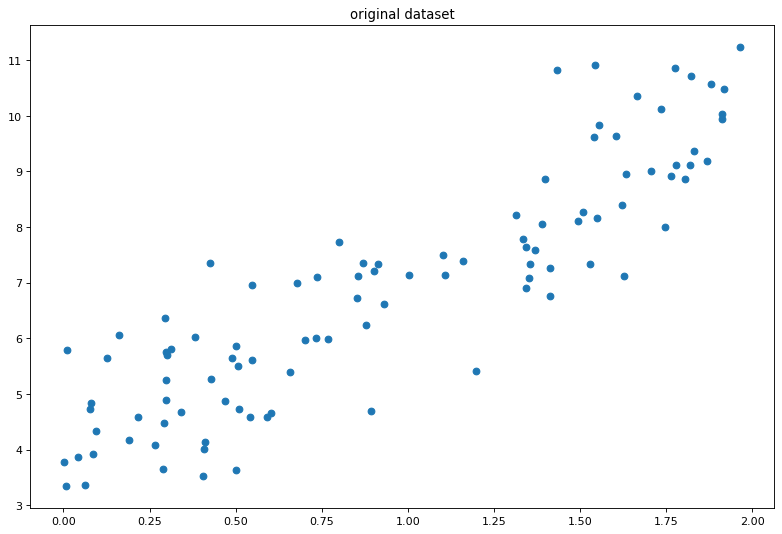

In [6]:
import numpy as np
from matplotlib import pyplot as plt

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.figure(figsize=(12,8),dpi=80)
plt.title("original dataset")
plt.scatter(X,y)

# 线性拟合器
1. 拟合方程
$$
    \hat y = W \cdot X + b
$$
2. 损失函数(MSE)
$$
    loss_{(MSE)} = \frac{1}{N}\sum_{k=1}^{N}{(y_{k} - \hat y_{k})}^{2}
$$
3. 矩阵参数解(最小二乘法)
$$
    W = {(X^{T} \cdot X)}^{-1}X^{T} \cdot y
$$

## 手动构造

In [10]:
X_b = np.c_[np.ones((100,1)),X]
omega_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
omega_best

array([[3.96779496],
       [3.0505575 ]])

通过两点做图画出该拟合直线

In [15]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(omega_best)
y_predict

array([[ 3.96779496],
       [10.06890996]])

Text(0.5, 1.0, 'prediction with datasets')

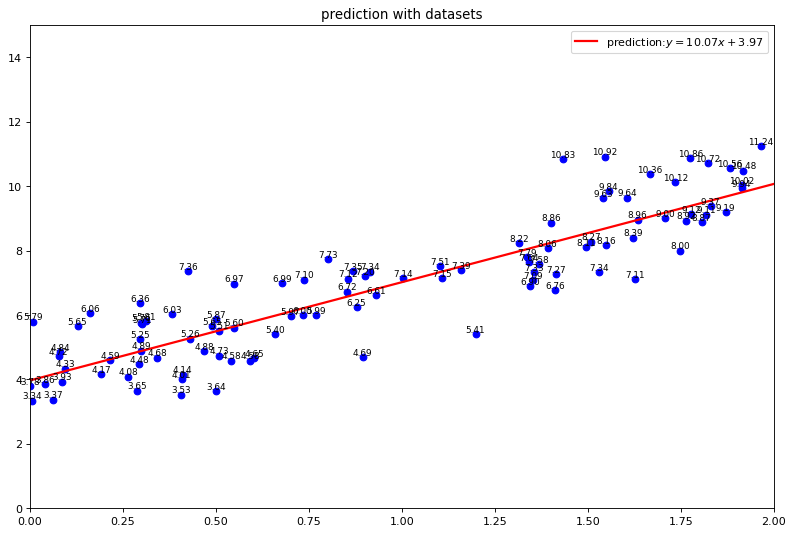

In [36]:
plt.figure(figsize=(12,8),dpi=80)
plt.plot(X_new, y_predict, lw=2, ls='-', color='red', 
         label=r'prediction:$y=%.2f x + %.2f$'%(y_predict[1],y_predict[0]))
plt.scatter(X, y, color='blue')
plt.axis([0,2,0,15])
for a,b in zip(X,y):
    plt.text(a,b,'%.2f'%b, ha='center',va='bottom',fontsize=8)
plt.legend()
plt.title("prediction with datasets")

## 使用sklearn代码

In [40]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)
print('a=%.8f \nb=%.8f'%(lin_reg.coef_,lin_reg.intercept_))
print(lin_reg.predict(X_new))

a=3.05055750 
b=3.96779496
[[ 3.96779496]
 [10.06890996]]


# 梯度下降法

## 批量梯度下降法

In [42]:
eta = 0.1 # learning rate
iteration = 1000 # total iterations
n = 100 # total # of data

w = np.random.randn(2,1) # initial value of w

for iters in range(iteration):
    grad = 2/n * X_b.T.dot(X_b.dot(w)-y)
    w = w - eta * grad
    
w

array([[3.96779496],
       [3.0505575 ]])

## 随机梯度下降法

1. 每一次梯度的计算只选用其中的一个数据进行，避免了巨量的矩阵运算
2. 根据代数自动调整训练的步长，快速收敛

In [44]:
epoch = 50
t0, t1 = 5, 50
n = 100

w = np.random.randn(2,1)

def learning_schedule(t):
    return t0 / (t + t1)

for epo in range(epoch):
    for item in range(n):
        random_index = np.random.randint(low=0,high=n)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        grad = 2 * xi.T.dot(xi.dot(w)-yi)
        eta = learning_schedule(epoch * n + item)
        w = w - eta * grad
        
w

array([[4.01152732],
       [2.99416354]])

In [46]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.02660347]), array([3.12049423]))

## 小批量梯度下降

# 多项式回归

$$
    y = 0.5X^{2} + X + 2 , x \in [-3,3]
$$

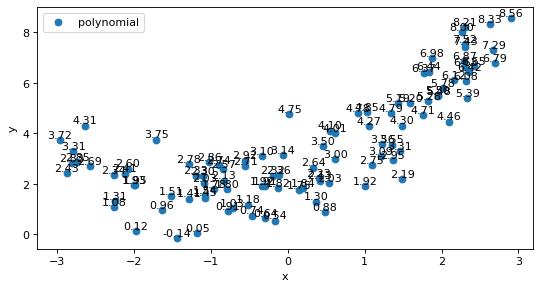

In [67]:
m = 100
Xp = 6 * np.random.rand(m,1) - 3
yp = 0.5 * Xp**2 + Xp + 2 + np.random.randn(m,1)

plt.figure(figsize=(8,4), dpi=80)
plt.scatter(Xp, yp, label='polynomial')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
for a,b in zip(Xp,yp):
    plt.text(a,b,'%.2f'%b,ha='center',va='bottom')

## 简单的多项式回归器

1. 使用 PolynomialFeatures 将多项式项转换为对应的输入维度
2. 相当于将$[X]$ 转化为$[X \space X^{2}]$

In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(Xp)
print(Xp[0])
print(X_poly[0])

[-0.21517511]
[-0.21517511  0.04630033]


In [57]:
lin_reg_p = LinearRegression()
lin_reg_p.fit(X_poly, yp)
lin_reg_p.intercept_,lin_reg_p.coef_

(array([1.99555296]), array([[1.01479144, 0.49584818]]))

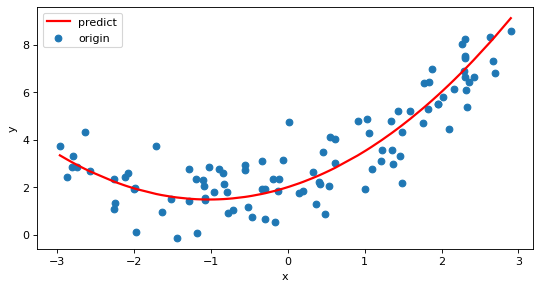

In [68]:
Xp_sort = np.sort(Xp,axis=0, kind='quicksort')
yp_pred = lin_reg_p.coef_[0,0] * Xp_sort + lin_reg_p.coef_[0,1] * Xp_sort**2 + lin_reg_p.intercept_

plt.figure(figsize=(8,4), dpi=80)
plt.scatter(Xp, yp, label='origin')
plt.plot(Xp_sort, yp_pred, lw=2, ls='-', color='red', label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## 模型验证

1. 模型的选择会决定预测最终的准确性
2. 在选定模型的情况下增加数据会在一定程度上减少误差

### 学习曲线判断拟合情况

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def plot_learning_curves(model, X, y):
    '''
    1. 首先将数据集分为训练集和测试集
    2. 其次在不断增加数据量的情况下计算训练集和测试集上的MSE
    3. 注意，训练集中的数据量不断增加，但是测试集数据量保持不变
    '''
    X_train, X_val, y_train, y_val = train_test_split(Xp,yp,test_size=0.2)
    train_errors, test_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        test_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.figure(figsize=(12,8))
    plt.plot(np.sqrt(train_errors),'r-+',lw=2,label="train set")
    plt.plot(np.sqrt(test_errors),'b-',lw=3,label="validation set")
    plt.legend()
    plt.title('train vs test RMSE')
    plt.xlabel("number of trainig data sample")
    plt.ylabel(r'$RMSE$')

#### 线性拟合
lin_reg_2

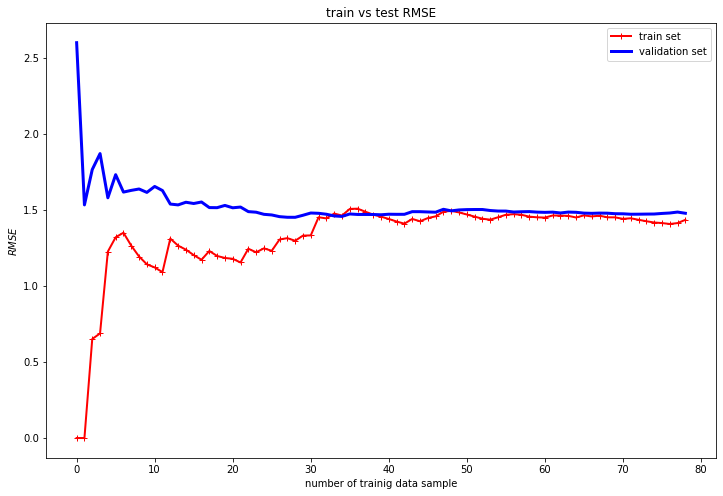

In [82]:
lin_reg_2 = LinearRegression()
plot_learning_curves(lin_reg_2,Xp,yp)

## 2阶多项式拟合
使用Pipeline

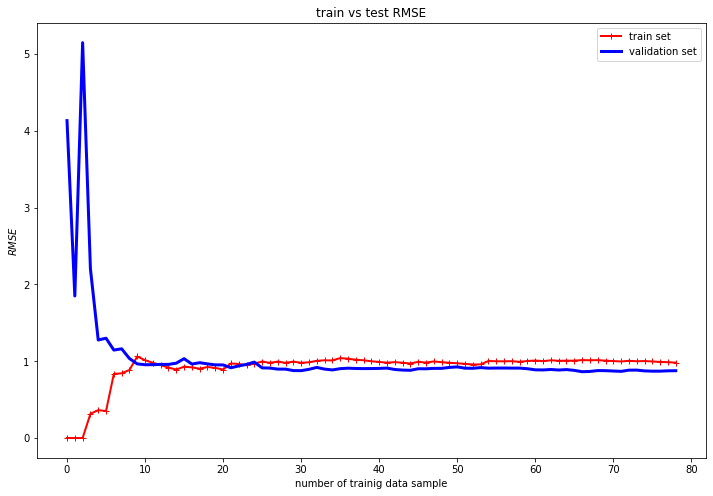

In [85]:
from sklearn.pipeline import Pipeline

polynomial_regression_pipeline = Pipeline((
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("sgd_reg",LinearRegression())
    ))
plot_learning_curves(polynomial_regression_pipeline, Xp, yp)

## 泛化能力分析
1. 偏差bias - 由于错误的模型设定产生，偏差越大越容易出现欠拟合
2. 方差Variance - 由于模型对于微小扰动敏感产生，方差越大越容易出现过拟合
3. 不可约误差 - 由于数据本身的噪声产生，需要进行数据清洗

## 线性模型正则化
1. 岭回归 Ridge
2. Lasso回归
3. Elastic Net

* 当有用特征较少而总体特征有很多时，使用Lasso和ElasticNet进行降维是十分有用的
* 一般来说，ElasticNet性能要强于Lasso

### 损失函数和评价函数
1. 损失函数作用于模型训练时，需要易于求导
2. 评价函数作用于模型测试时，需要接近客观表现
3. 一个例子，岭回归即作用于模型训练过程中，能够尽可能的选择较小的模型参数

### 岭回归
$$
    J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}{\theta_{i}}^{2}
$$
其中$\alpha$是模型强度因子

线性函数
$$
    y = 4 + 3x
$$

In [87]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[8.4998208]])

In [91]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([8.63892488])

### Lasso回归
$$
    J(\theta) = MSE(\theta) + \alpha\sum_{i=1}^{n}|\theta_{i}|
$$

In [92]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([8.39618573])

### ElasticNet
$$
    J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^{n}|\theta_{i}| + \frac{1-r}{2}\alpha\sum_{i=1}^{n}{\theta_{i}}^{2}
$$

In [94]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([8.28015523])

# Logistic回归

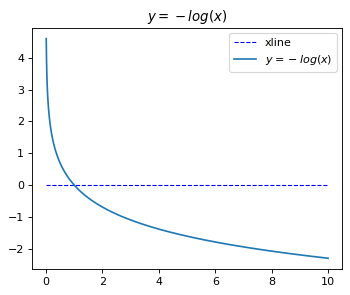

In [113]:
log_x = np.arange(0.01,10,0.01)
xline = np.zeros_like(log_x)
log_y = -np.log(log_x)
plt.figure(figsize = (5,4),dpi=80)
plt.plot(log_x,xline, lw=1,ls='--',color='blue',label='xline')
plt.plot(log_x, log_y,label=r'$y=-log(x)$')
plt.title(r'$y = -log(x)$')
plt.legend()

1. 首先将损失函数输出值映射到$[0,1]$区间上
2. 其次通过log损失函数计算损失值
3. 这样做的目的是放大位于中间的输出值，增加灵敏度，同时对极度贴近两端的输出值做出准确的预测

## Logistic函数 | Sigmoid函数
$$
    \sigma(x) = \frac{1}{1+e^{-x}}
$$

## 损失函数 - 熵
$$
    J(\theta) = -\frac{1}{N}\sum_{i=1}^{N}[y_{label}^{i}log(y_{pred}^{i})+(1-y_{label}^{i})log(1-y_{pred}^{i})]
$$

## 损失函数求导
 i代表样本数量；j代表属性位置
$$
    \frac{\partial}{\partial\theta_{j}}J(\theta_{j}) = 
    \frac{1}{N}\sum_{i=1}^{N}[\sigma(\theta^{T}\cdot x^{i})-y^{i}]x_{j}^{i}
$$

## 鸢尾花数据Logistic回归
使用花瓣宽度 $data[col=3]$ 识别Virginica  $target==2$

In [118]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
list(iris.keys())
X_log = iris['data'][:,3:]
y_log = (iris['target'] == 2).astype(np.int32)

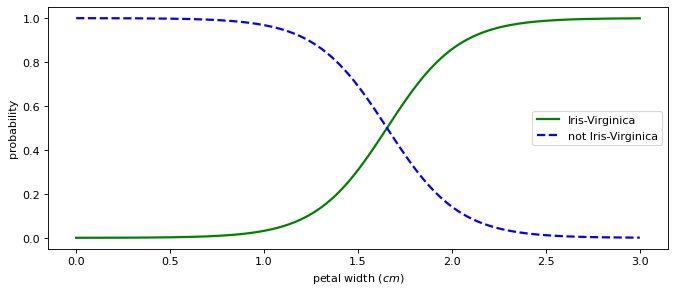

In [130]:
log_reg = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5)
log_reg.fit(X_log,y_log)

X_log_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_log_new)

plt.figure(figsize=(10,4),dpi=80)
plt.plot(X_log_new, y_proba[:,1], lw=2, ls='-',color='g', label='Iris-Virginica')
plt.plot(X_log_new, y_proba[:,0], lw=2, ls='--',color='b', label='not Iris-Virginica')
plt.xlabel(r'petal width $(cm)$')
plt.ylabel('probability')
plt.legend()

In [131]:
log_reg.predict([[1.7],[1.65],[1.6],[1.55],[1.5]])

array([1, 0, 0, 0, 0], dtype=int32)

## Softmax函数
* 相当于是对所有属性的输出值进行指数加权平均
* 其中$k$是第$k$个属性分量
* 其中$s_{k}(\vec x)$表示输出值的第k个分量
* 其中$D$表示属性分量总数量

$$
    \hat p_{k} = 
    \sigma[s(\vec x)] = 
    \frac{exp(s_{k}(\vec x))}{\sum_{j=1}^{D}exp(s_{j}(\vec x))}
$$

## 损失函数 - 交叉熵

$$
    J(\Theta) = -\frac{1}{N}\sum_{i=1}^{N}\sum_{k=1}^{D}y_{k}^{(i)}log(\hat p_{k}^{(i)})
$$

## 损失函数求导

$$
    \frac{\partial J(\Theta)}{\partial\Theta} = 
    \nabla_{\theta_{k}}J(\Theta) = 
    \frac{1}{N}\sum_{i=1}^{N}(\hat p_{k}^{(i)}-y_{k}^{(i)})\vec x^{(i)}
$$

## 鸢尾花数据MvM Logistic回归

In [169]:
X_softmax = iris['data'][:,(2,3)] # petal length, petal width
y_softmax = iris['target']

softmax_reg = LogisticRegression(multi_class='multinomial',solver='lbfgs', C=10)
softmax_reg.fit(X_softmax, y_softmax)

print(softmax_reg.predict([[5, 2]])[0])
print(softmax_reg.predict_log_proba([[5, 2]]))

2
[[-14.26490421  -2.85609209  -0.05921261]]


(24, 59)


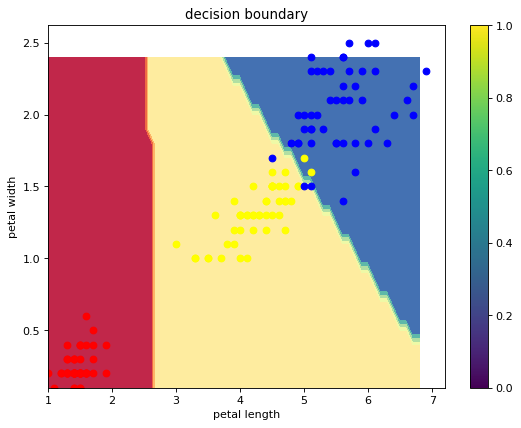

In [242]:
def plot_decision_boundary(model, X, y):
    x_label = np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1).reshape(-1,1)
    y_label = np.arange(np.min(X[:,1]),np.max(X[:,1]),0.1).reshape(-1,1)
    xx,yy = np.meshgrid(x_label,y_label)
    print(yy.shape)
    zz = np.zeros_like(xx)
    for la in range(x_label.shape[0]):
        for lb in range(y_label.shape[0]):
            zz[lb, la] = model.predict([[x_label[la][0],y_label[lb][0]]])
    plt.figure(figsize=(8,6),dpi=80)
    plt.title('decision boundary')
    plt.xlabel('petal length')
    plt.ylabel('petal width')
    plt.contourf(xx,yy,zz,cmap=plt.cm.Spectral)
    for index in range(len(y)):
        if(y[index] == 0) :
            plt.scatter(X[index,0],X[index,1],color='red',label="iris-viginica")
        elif(y[index] == 1):
            plt.scatter(X[index,0],X[index,1],color='yellow',label="iris-versicolor")
        else:
            plt.scatter(X[index,0],X[index,1],color='blue',label="iris-setosa")  
    plt.colorbar()

plot_decision_boundary(softmax_reg, X_softmax, y_softmax)